In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 12.3MB/s 
     |████████████████████████████████| 1.2MB 27.8MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 204kB 37.7MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
Mounted at /content/gdrive


In [ ]:
!pip install voila
#restart before you run this
!jupyter serverextension enable --sys-prefix voila 

In [ ]:
from PIL import Image
import os
import pandas as pd

In [ ]:
from fastbook import *
from fastai.vision.all import *

In [ ]:
MAIN_PATH = os.getcwd()
MAIN_PATH

'/content'

In [ ]:
#Scrapping data form bing using azure Key API search

key = os.environ.get('AZURE_SEARCH_KEY', 'c52733d0c18e4981bdbd46c9a666b662')
results = search_images_bing(key, 'grizzly bear')
#to get the url of results
ims = results.attrgot('contentUrl')
len(ims)

150

In [ ]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

if not path.exists():
  path.mkdir()
  for bear in bear_types:
    dest = (path/bear)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{bear} bear')
    #using fastai download_images func. to download all the url for each of the search terms 
    download_images(dest, urls=results.attrgot('contentUrl'))

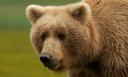

In [ ]:
#Viewing the images downloaded
ims[1]
dest = os.path.join(MAIN_PATH, 'images/')
gest = os.mkdir(dest)
ndest = os.path.join(MAIN_PATH, 'images/grizzly.jpg')
download_url(ims[0], ndest)
im = Image.open(ndest)
im.to_thumb(128,128)

In [ ]:
fns = get_image_files(path)
fns

(#398) [Path('bears/grizzly/00000143.jpg'),Path('bears/grizzly/00000062.jpg'),Path('bears/grizzly/00000039.jpg'),Path('bears/grizzly/00000005.jpg'),Path('bears/grizzly/00000010.jpg'),Path('bears/grizzly/00000101.jpg'),Path('bears/grizzly/00000059.jpg'),Path('bears/grizzly/00000016.jpg'),Path('bears/grizzly/00000028.jpg'),Path('bears/grizzly/00000133.jpg')...]

In [ ]:
#To check files that are not safe or corrupted
failed = verify_images(fns)
failed
#To remove the files
failed.map(Path.unlink)

(#10) [None,None,None,None,None,None,None,None,None,None]

In [ ]:
#DataBlock is used to quickly build Datasets and DataLoaders
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    #return the list of all images in get_image_files
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    #parent_label is a function that gets the namr of the folder a file is in
    #get_y is a function thet is used to create labels
    get_y=parent_label,
    item_tfms=Resize(128)
)

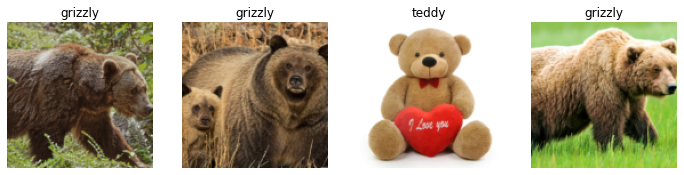

In [ ]:
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
#i think it loads data created with dataablock
doc(DataLoaders)

In [ ]:
#By default Resize crops the images to fit a square shape of the size requested,
#using the full width or height. This can result in losing some important details.
#Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

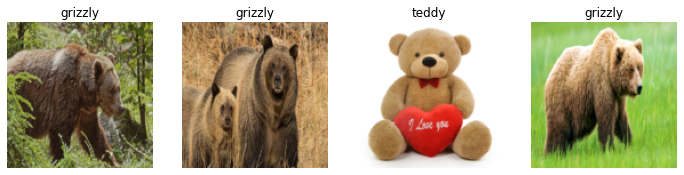

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

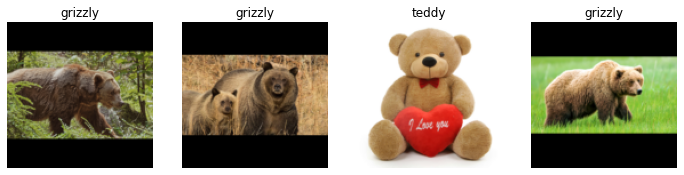

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

All of these approaches seem somewhat wasteful, or problematic. If we squish or stretch the images they end up as unrealistic shapes, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. If we crop the images then we remove some of the features that allow us to perform recognition. For instance, if we were trying to recognize breeds of dog or cat, we might end up cropping out a key part of the body or the face necessary to distinguish between similar breeds. If we pad the images then we have a whole lot of empty space, which is just wasted computation for our model and results in a lower effective resolution for the part of the image we actually use.

Instead, what we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

In fact, an entirely untrained neural network knows nothing whatsoever about how images behave. It doesn't even recognize that when an object is rotated by one degree, it still is a picture of the same thing! So actually training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

Here's another example where we replace Resize with RandomResizedCrop, which is the transform that provides the behavior we just described. The most important parameter to pass in is min_scale, which determines how much of the image to select at minimum each time:

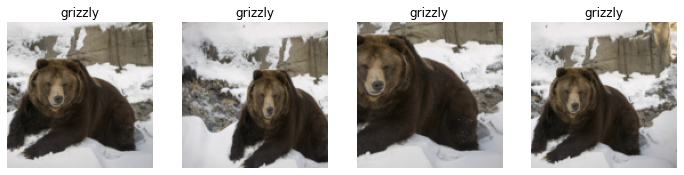

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)
#unique=True is used to ahve the same image repeated with diffrent versions of RandomResizedCrop transform

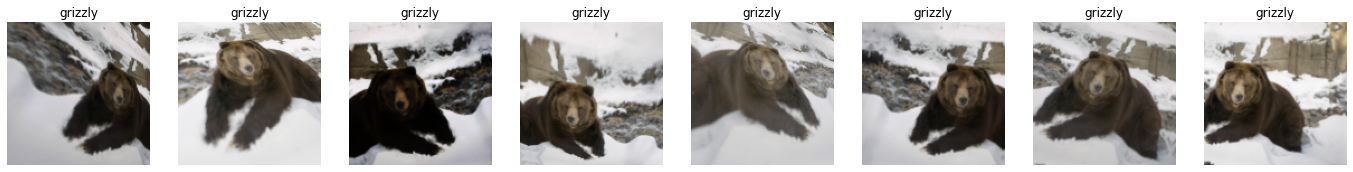

In [ ]:
#Data augmentaion with fastai
#Examples of common data augmentation techniques for images are 
#rotation, flipping, perspective warping, brightness changes and contrast changes

bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=1, unique=True)

In [ ]:
#Building a model
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = bears.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

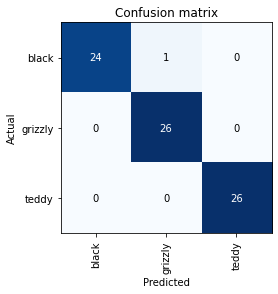

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

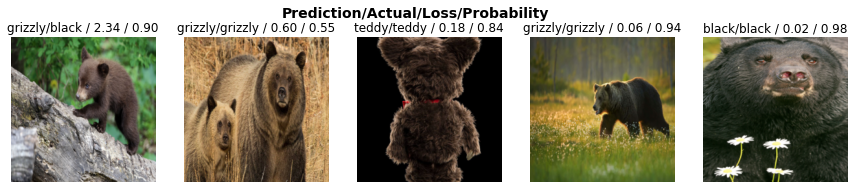

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
#fastai includes a handy GUI for data cleaning called ImageClassifierCleaner 
#that allows you to choose a category and the training versus validation set 
#and view the highest-loss images (in order), along with menus to allow images 
#to be selected for removal or relabeling:

In [ ]:
#Turning our model into an online application
#Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production.
#Remember that a model consists of two parts: the architecture and the trained parameters. The easiest way to save the model is to save both of these,
#because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the export method.

#This method even saves the definition of how to create your DataLoaders. This is important, because otherwise you would have to redefine how to transform your
#data in order to use your model in production. fastai automatically uses your validation set DataLoader for inference by default, so your data augmentation will not be applied, which is generally what you want.

#When you call export, fastai will save a file called "export.pkl":

SyntaxError: ignored

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
#creating an inference. 
#an inference is When we use a model for getting predictions, instead of training

learn_inf = load_learner(path/'export.pkl')
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([8.7345e-04, 9.9908e-01, 5.0915e-05]))

In [ ]:
#how the above result is represented
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [ ]:
#creating a notebook app from the model
# all we need to build is 
# IPython widgets
# Voila

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload
# or you can upload an image from dir
#btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

FileUpload(value={}, description='Upload')

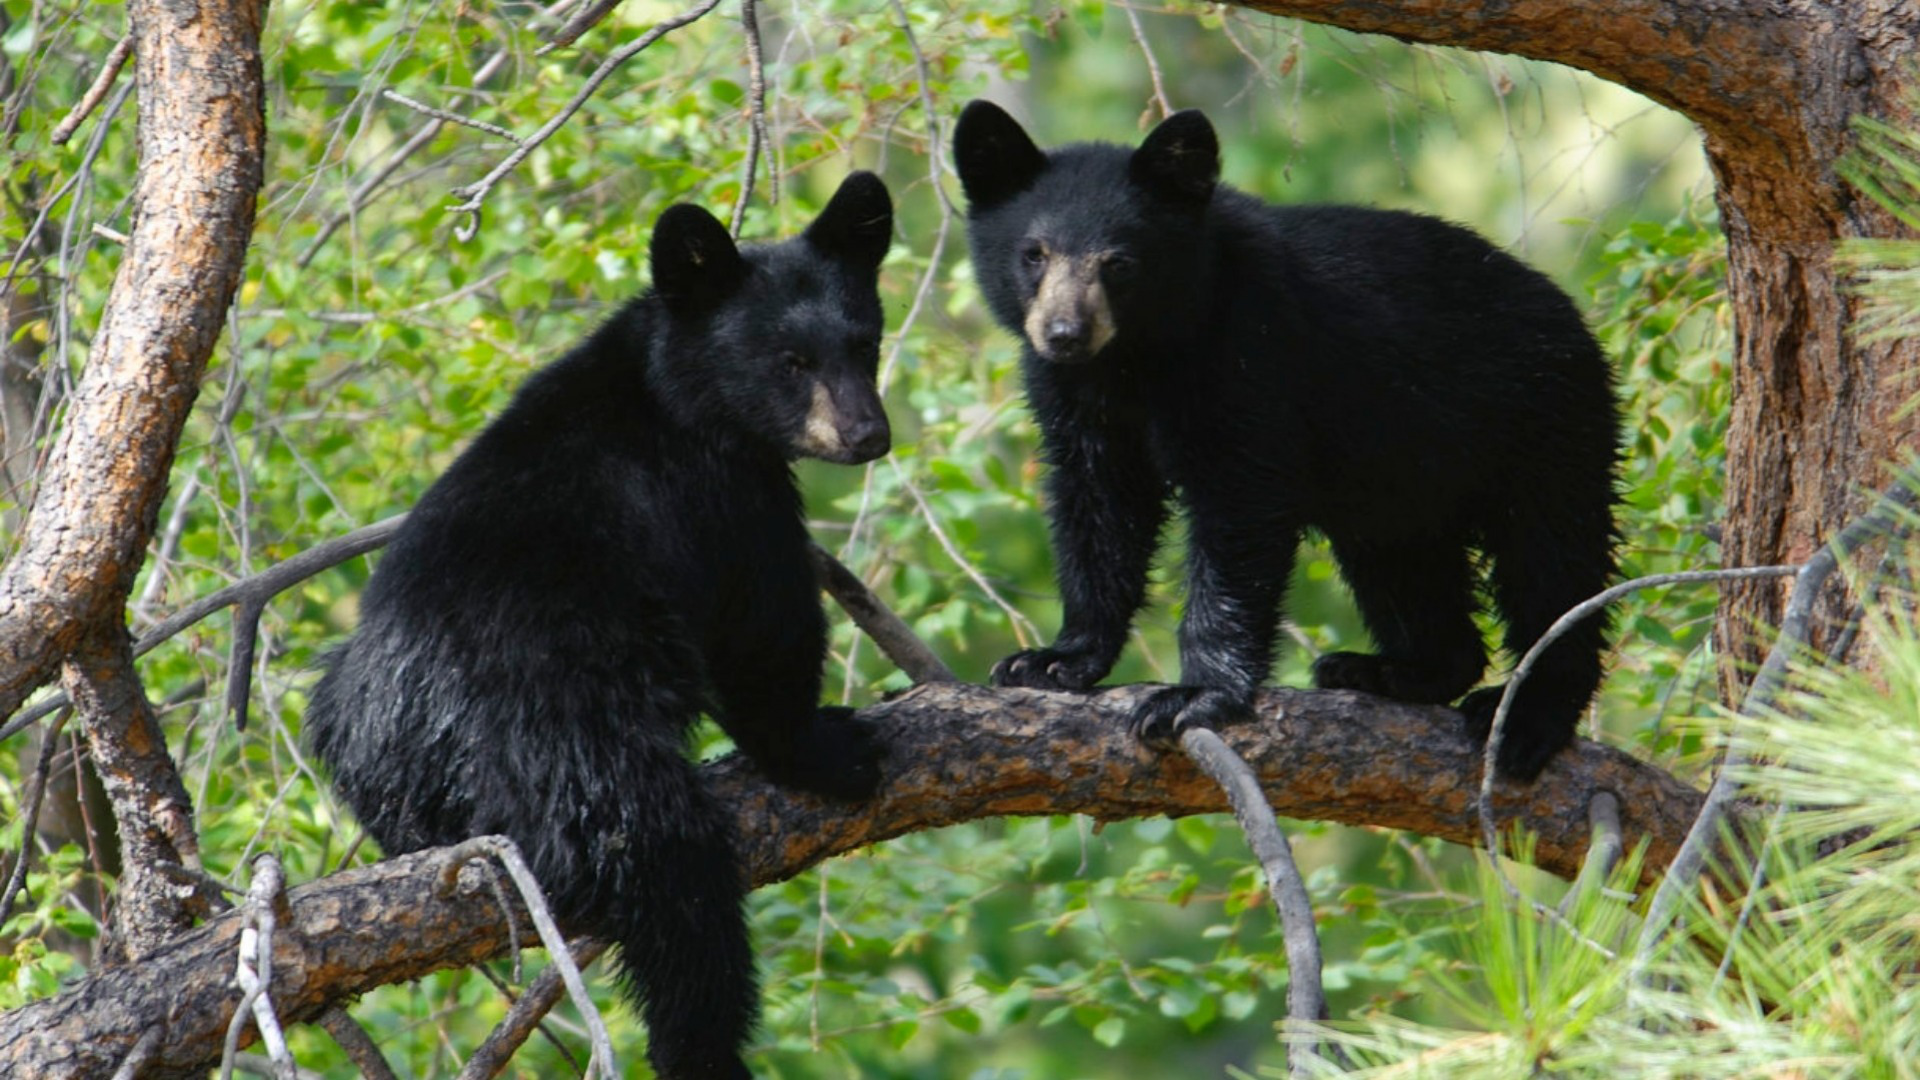

In [ ]:
img = PILImage.create(btn_upload.data[-1])
img

In [ ]:
#we can output widget to display it
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: black; Probability: 1.0000')

In [ ]:
#Creating a button to do classification
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
#We'll also need a click event handler; that is, a function that will be called when it's pressed. 
#We can just copy over the lines of code from above:

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#We put them in a verticalbox to complete the GUI
btn_upload = widgets.FileUpload()
display(widgets.VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred]))

In [ ]:
from IPython.display import display

In [ ]:
#Turning your notebook into a real app
#Deploying our app